# Phase 1

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re

basic_stopwords = set(stopwords.words('english'))

# Initialize necessary NLP tools
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if pd.isnull(text):
        return ""
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    tokens = word_tokenize(text)
    # Stemming
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    # Lemmatization
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in stemmed_tokens]
    # Join tokens back into a string
    return ' '.join(lemmatized_tokens)

# Load datasets (Replace with your dataset paths)
train_data = pd.read_csv('train.csv')
valid_data = pd.read_csv('valid.csv')

# Apply preprocessing to train and validation data
train_data['processed_body'] = train_data['Body'].apply(preprocess_text)
valid_data['processed_body'] = valid_data['Body'].apply(preprocess_text)

# Vectorization using Bag-of-Words
bow_vectorizer = CountVectorizer(max_features=5000)
train_bow = bow_vectorizer.fit_transform(train_data['processed_body'])
valid_bow = bow_vectorizer.transform(valid_data['processed_body'])

# Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
train_tfidf = tfidf_vectorizer.fit_transform(train_data['processed_body'])
valid_tfidf = tfidf_vectorizer.transform(valid_data['processed_body'])

# Save processed data (Optional)
train_data.to_csv('processed_train.csv', index=False)
valid_data.to_csv('processed_valid.csv', index=False)

# Display processed train data preview
print("Processed Train Data Sample:")
train_data.head()


Processed Train Data Sample:


,Id,Title,Body,Tags,CreationDate,Y,processed_body
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE,im alreadi familiar with repeat task everi n s...
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ,id like to understand whi java 8 option were d...
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ,i am attempt to overlay a titl over an imag wi...
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ,the question is veri simpl but i just could no...
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ,im use custom floatingactionmenu i need to imp...


In [3]:
print("\nBag-of-Words Sample:")
train_bow.toarray()[:5]


Bag-of-Words Sample:


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [4]:
print("\nTF-IDF Sample:")
train_tfidf.toarray()[:5]



TF-IDF Sample:


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Phase 2

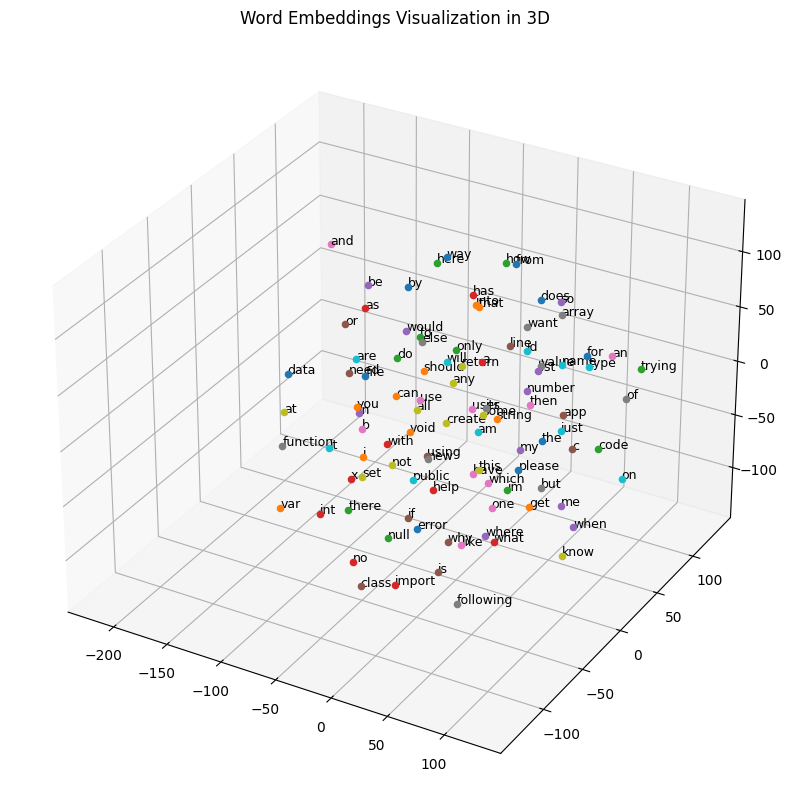

Query: How to train a machine learning model?
Similar Questions:
1: how to take a build of python project to deploy it as a website for public (Similarity: 0.89)
2: from a java based application perspective whats the purpose of oracle client installed on a server (Similarity: 0.88)
3: where to start with c gui (Similarity: 0.88)
4: converting hive to sparkneed suggestion (Similarity: 0.88)
5: java program to build and run a maven project (Similarity: 0.88)
Phase 2 complete. Word2Vec model trained, embeddings visualized, and similarity retrieval implemented.


In [8]:
# import pandas as pd
# import re
# from bs4 import BeautifulSoup
# from gensim.models import Word2Vec
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# from sklearn.metrics.pairwise import cosine_similarity
#
# # Combine Title and Body for Word2Vec training
# train_sentences = train_data['Title'].tolist() + train_data['Body'].tolist()
# train_sentences = [sentence.split() for sentence in train_sentences if isinstance(sentence, str)]
#
# # Train Word2Vec model
# word2vec_model = Word2Vec(sentences=train_sentences, vector_size=100, window=5, min_count=2, workers=4)
#
# # Save Word2Vec model
# word2vec_model.save("word2vec_model.model")
#
# # Visualize word embeddings
# def visualize_embeddings_3d(model, sample_size=100):
#     """Visualize word embeddings using t-SNE in 3D."""
#     from mpl_toolkits.mplot3d import Axes3D
#     words = list(model.wv.index_to_key)[:sample_size]
#     word_vectors = np.array([model.wv[word] for word in words])
#
#     tsne = TSNE(n_components=3, random_state=0)
#     reduced_vectors = tsne.fit_transform(word_vectors)
#
#     fig = plt.figure(figsize=(10, 10))
#     ax = fig.add_subplot(111, projection='3d')
#     for i, word in enumerate(words):
#         ax.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1], reduced_vectors[i, 2])
#         ax.text(reduced_vectors[i, 0], reduced_vectors[i, 1], reduced_vectors[i, 2], word, fontsize=9)
#
#     plt.title("Word Embeddings Visualization in 3D")
#     plt.show()
#
# # Visualize embeddings in 3D
# visualize_embeddings_3d(word2vec_model)
#
# # Generate document vectors by averaging word vectors
# def document_vector(doc, model):
#     """Generate a document vector by averaging word vectors."""
#     if not isinstance(doc, str):
#         return np.zeros(model.vector_size)
#     words = [word for word in doc.split() if word in model.wv.index_to_key]
#     if not words:  # If no valid words, return a zero vector
#         return np.zeros(model.vector_size)
#     return np.mean(model.wv[words], axis=0)
#
# train_data['DocVector'] = train_data['Title'] + " " + train_data['Body']
# train_data['DocVector'] = train_data['DocVector'].apply(lambda x: document_vector(x, word2vec_model))
#
# # Cosine Similarity Calculation
# def find_similar_questions(query, data, model, top_n=5):
#     """Find the top_n most similar questions to the query."""
#     query_vector = document_vector(query, model)
#     similarities = []
#     for idx, row in data.iterrows():
#         similarity = cosine_similarity([query_vector], [row['DocVector']])[0][0]
#         similarities.append((idx, similarity))
#     similarities = sorted(similarities, key=lambda x: x[1], reverse=True)[:top_n]
#     return data.iloc[[idx for idx, _ in similarities]], [sim for _, sim in similarities]
#
# # Example usage
# query = "How to train a machine learning model?"
# similar_questions, similarities = find_similar_questions(query, train_data, word2vec_model)
#
# print("Query:", query)
# print("Similar Questions:")
# for i, (question, similarity) in enumerate(zip(similar_questions['Title'], similarities)):
#     print(f"{i + 1}: {question} (Similarity: {similarity:.2f})")
#
# print("Phase 2 complete. Word2Vec model trained, embeddings visualized, and similarity retrieval implemented.")
